**TASKS FOR MEETING ON 22 MARCH 2023:**

- ~~AUC per feature~~
- ~~Change activation and regularization~~
- ~~Balancing VS not balancing~~
- ~~Check feature normalization only in the relevant~~
- ~~Include performance on validation and test~~
- Resampling from the training data or randoms value in the weights (later): ensemble
- ~~Save dataframes of train, valid, test with regularization: no categorical variables~~

# 1. RNN for the original whole dataset

In [1]:
# Import of required libraries and functions from 'make_dataset' script
import os
from make_dataset import Discotope_Dataset
import numpy as np
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_auc_score
from tqdm import tqdm

C:\Users\minij\anaconda3\envs\special_course\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.random.set_seed(1234)

In [4]:
def data_load(name_set, data_dir, separate=False):
    
    '''
    Function to load training, validation or test data from the folder/directory you have storaged the whole dataset
        - 'name_set': text variable with the type of data set to load ('train', 'test', 'valid')
        - 'data_dir': directory where you have storaged the data set (in my case is '../Data/')
        - 'separate': boolean that returns the PDBs and AF2 sets separately (only when True)
    
    Output:
        - 'X_all': all observations from both solved and predicted structures all together
        - 'y_all': all labels from both solved and predicted structures all together
        - 'N_solved': number of observations from solved structures (in case of wanted to unmerge the 'all' array)
        - 'N_af2': number of observations from predicted structures (in case of wanted to unmerge the 'all' array)
    '''
    
    # 'Pathlib module' load to work with windows path
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    # List of all subdirectories inside the data directory
    dirs = [d for d in os.listdir(data_dir)]
    
    # 're' module to use regex for filtering the specific directories according to the type of data set to load
    pattern = '.*' + name_set + '.*'
    R = re.compile(pattern)
    filtered = [folder for folder in dirs if R.match(folder)]
    
    # Loading the data set for solved structures and AlphaFold2 predicted structures
    path_af2 = data_dir + filtered[0] + '/dataset.pt'
    path_solved = data_dir + filtered[1] + '/dataset.pt'
    set_af2 = torch.load(path_af2)
    set_solved = torch.load(path_solved)
    
    # Stack all features and targets to one big array
    X_set_solved = np.concatenate([sample["X_arr"] for sample in set_solved])
    y_set_solved = np.concatenate([sample["y_arr"] for sample in set_solved])
    X_set_af2 = np.concatenate([sample["X_arr"] for sample in set_af2])
    y_set_af2 = np.concatenate([sample["y_arr"] for sample in set_af2])
    
    # Nº of observations for each subtype of data set
    N_set_solved = X_set_solved.shape[0]
    N_set_af2 = X_set_af2.shape[0]
    
    # Stack all features and targets from solved and predicted structures into only one big
    X_set_all = np.concatenate((X_set_solved, X_set_af2), axis=0)
    y_set_all = np.concatenate((y_set_solved, y_set_af2), axis=0)
    
    if (separate==True):
        return(X_set_all, y_set_all, X_set_solved, y_set_solved, X_set_af2, y_set_af2)
    else:
        return(X_set_all, y_set_all, N_set_solved, N_set_af2)

In [5]:
def dataframe_load(name_set, data_dir):
    
    '''
    Function to load training, validation or test dataframes from the folder/directory you have storaged the whole dataset.
    This function is specifically to have the original dataframes of the data, and their corresponding description
        - 'name_set': text variable with the type of data set to load ('train', 'test', 'valid')
        - 'data_dir': directory where you have storaged the data set (in my case is '../Data/')
    
    Output:
        - 'set_af2': dataframe for AF2 predicted structures
        - 'set_solved': dataframe for PDB solved structures
    '''
    
    # 'Pathlib module' load to work with windows path
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    # List of all subdirectories inside the data directory
    dirs = [d for d in os.listdir(data_dir)]
    
    # 're' module to use regex for filtering the specific directories according to the type of data set to load
    pattern = '.*' + name_set + '.*'
    R = re.compile(pattern)
    filtered = [folder for folder in dirs if R.match(folder)]
    
    # Loading the data set for solved structures and AlphaFold2 predicted structures
    path_af2 = data_dir + filtered[0] + '/dataset.pt'
    path_solved = data_dir + filtered[1] + '/dataset.pt'
    set_af2 = torch.load(path_af2)
    set_solved = torch.load(path_solved)
    
    return(set_af2, set_solved)

In [6]:
def remove_NaN(data, y):
    
    '''
    Function to remove NaN values (some PDB entries have RSA NaN values)
        - 'data': numpy array with the specific (train, valid, test) data
        - 'y': numpy array with the specific (train, valid, test) labels
    
    Output:
        - 'data_noNaN': array withouth the entries/observations that contain NaN values
    '''
    
    # Merging X and y arrays all together
    joint_data = np.hstack((data, y.reshape(-1, 1)))
    
    # Removal of NaN entries
    nan_rows = np.isnan(joint_data).any(axis=1)
    data_noNaN = joint_data[~nan_rows, :]
    
    # Demerging the final array into X and y
    X_noNaN = data_noNaN[:, 0:data.shape[1]]
    y_noNaN = data_noNaN[:,-1]
    
    return(X_noNaN, y_noNaN)

In [7]:
def normalize_train(X):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
    '''
    
    # Create a copy of the X vector to do the normalization
    X_scaled = X.copy()
    
    # Create an instance of MinMaxScaler
    scaler = StandardScaler()
    
    # Fit the scaler to the data 
    #scaler.fit(X_scaled[:, 532:534])
    scaler.fit(X_scaled)
    
    # Transform the data
    #X_scaled[:, 532:534] = scaler.fit_transform(X_scaled[:, 532:534])
    X_scaled = scaler.fit_transform(X_scaled)
    return(X_scaled)

In [8]:
def Z_transform_train(X, cols_to_select):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
    '''
    
    # Obtain the mean and standard deviation for each feature on the array
    X_mean = np.mean(X[:, cols_to_select], axis=0)
    X_std = np.std(X[:, cols_to_select], axis=0)
    
    # Z-transform (standardization)
    X[:, cols_to_select] = (X[:, cols_to_select] - X_mean)/X_std
    return(X, X_mean, X_std)

In [9]:
def Z_transform_valid(X, mean_train, sd_train, cols_to_select):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
        - 'mean_train': mean from standardized training set
        - 'sd_train': standard deviation from standardized training set
    '''
    
    # Z-transform (standardization)
    X[:, cols_to_select] = (X[:, cols_to_select] - mean_train)/sd_train
    return(X)

In [10]:
def class_weight_calculator(y_train):
        
    '''
    Function to calculate the class weights for the unbalanced data
        - 'y_train': training labels (contains 0 and 1)
    '''
    
    # Compute the class weights with sklearn function
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Convert the class weights to a dictionary
    class_weight = dict(enumerate(class_weights))
    return(class_weight)

In [11]:
# Neuronal network model with one layer
def nn_model(train_data, y_train, valid_data, y_valid, act_fun, loss_fun, alpha, class_weight_fn, balancing=True):
    
    '''
    Function to create and train/validate the feed-forward neuronal network with only 1 hidden layer
        -'train_data': X train standardized
        -'y_train': training labels
        -'valid_data': X validation standardized
        -'y_valid': validation labels
        -'act_fun': activation function
        -'loss_fun': loss function
        -'class_weight_calculator': function to calculate the weights for each class
        -'balancing': True/False argument for incorporating balancing in classes
    
    Output:
        -'model': neural network model trained
        -'history': attributes obtained during fitting the model
    '''
    
    # Calculation of the class weights with function previously defined
    class_weight = class_weight_fn(y_train)
    
    # Normalization of the class_weight to sum 1
    tot = class_weight[0] + class_weight[1]
    class_weight[0] = class_weight[0]/tot
    class_weight[1] = class_weight[1]/tot
    
    # Implementation of keras for creating a sequential model with 1 layer
    tf.random.set_seed(1234)
    from keras.layers import Dense, Dropout
    from keras import regularizers, metrics
    
    model = keras.Sequential()
    # Input layer with train_data.shape neurons and a hidden layer with 1 neuron
    model.add(Dense(1, activation=act_fun, input_shape=train_data.shape[1:], kernel_regularizer=regularizers.l2(alpha)))
    # Output layer with sigmoid activation (better for binary classification)
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(alpha)))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=loss_fun, metrics=
                  ['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC(), loss_fun])
    
    if (balancing == True):
        history = model.fit(train_data, y_train, epochs = 50, batch_size=128, verbose=0, class_weight=class_weight, 
                            validation_data = (valid_data, y_valid))
    else:
        history = model.fit(train_data, y_train, epochs = 50, batch_size=128, verbose=0, 
                            validation_data = (valid_data, y_valid))
    
    return(model, history)

In [12]:
def loss_plot(loss_values):
    
    '''
    Function to plot the loss curve of the training of the model
        - 'loss_values': array with the loss values for each iteration of the training
    '''
    
    plt.plot(loss_values, label = 'Train')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

In [13]:
def ROC_AUC(y_true, y_hat):
    
    '''
    Function to obtain the AUC value based on the ROC curve
        - 'y_true': y original values
        - 'y_hat': y predicted values
        
    Output:
        - 'ROC_auc': AUC value
    '''
    
    fpr, tpr, _ = metrics.roc_curve(y_true, y_hat)
    ROC_auc = metrics.auc(fpr, tpr)
    return(ROC_auc)

In [14]:
def PR_AUC(y_true, y_hat):
    
    '''
    Function to obtain the AUC value based on the precision and recall parameters
        - 'y_true': y original values
        - 'y_hat': y predicted values
        
    Output:
        - 'PR_auc': AUC value
    '''
    
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_hat)
    PR_auc = metrics.auc(recall, precision)
    return(PR_auc)

In [15]:
# Epitope rank percentile score
# https://github.com/Magnushhoie/discotope3/blob/main/src/models/mlscripts.py#L55

def get_percentile_score_arr(
    scores: np.array,
    epitopes: np.array,
):
    
    """Find mean predicted epitope rank percentile score from the scores (y_hat) and the epitopes (y_true)"""
    epitopes_bool = epitopes.astype(bool)
    assert epitopes_bool.dtype == "bool"

    c = scores[epitopes_bool].mean()
    c_percentile = (c > scores).mean()

    return c_percentile

In [16]:
# Data loading for training, validation, and test data sets (needs a couple of minutes)
X_train, y_train, X_train_PDB, y_train_PDB, X_train_af2, y_train_af2 = data_load(name_set='train', data_dir='../Data/', separate = True)
X_valid, y_valid, X_valid_PDB, y_valid_PDB, X_valid_af2, y_valid_af2 = data_load(name_set='valid', data_dir='../Data/', separate = True)
X_test, y_test, X_test_PDB, y_test_PDB, X_test_af2, y_test_af2 = data_load(name_set='test', data_dir='../Data/', separate = True)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((480297, 536), (480297,), (119792, 536), (119792,), (14084, 536), (14084,))

In [17]:
# Data manipulation to remove all PDB entries with NaN values in the RSA feature (535)
X_train, y_train = remove_NaN(data=X_train, y=y_train)
X_valid, y_valid = remove_NaN(data=X_valid, y=y_valid)
X_test, y_test = remove_NaN(data=X_test, y=y_test)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((463580, 536), (463580,), (118084, 536), (118084,), (12983, 536), (12983,))

In [18]:
# Data normalization
cols = list(range(0, 512)) + [532] + [533] + [535]
X_train_sc, mean_X_train, sd_X_train = Z_transform_train(X_train, cols_to_select=cols)
X_valid_sc = Z_transform_valid(X_valid, mean_X_train, sd_X_train, cols_to_select=cols)
X_test_sc = Z_transform_valid(X_test, mean_X_train, sd_X_train, cols_to_select=cols)

X_train_sc.shape, X_valid_sc.shape, X_test_sc.shape

((463580, 536), (118084, 536), (12983, 536))

In [19]:
# Class unbalanced in train
zero, one = np.bincount(y_train.astype(int))
total = zero + one
print("Class count (train):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (train):

      Total: 463580
      Epitope label: 42458 (9.16% of total)


In [20]:
# Class unbalanced in valid
zero, one = np.bincount(y_valid.astype(int))
total = zero + one
print("Class count (validation):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (validation):

      Total: 118084
      Epitope label: 9810 (8.31% of total)


In [21]:
# Class unbalanced in train
zero, one = np.bincount(y_test.astype(int))
total = zero + one
print("Class count (test):\n\n      Total: {}\n      Epitope label: {} ({:.2f}% of total)".format(total, one, 100*one/total))

Class count (test):

      Total: 12983
      Epitope label: 792 (6.10% of total)


In [22]:
# Calculation of the class weights with function previously defined
class_weight = class_weight_calculator(y_train)
    
# Normalization of the class_weight to sum 1
tot = class_weight[0] + class_weight[1]
class_weight[0] = class_weight[0]/tot
class_weight[1] = class_weight[1]/tot
    
print("Class weight implemented")
class_weight

Class weight implemented


{0: 0.09158721256309592, 1: 0.9084127874369041}

In [23]:
# Checking standarization on numerical features
pd.DataFrame(X_train_sc[:, 0:512]).describe()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,...,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05,4.635800e+05
mean,-2.553527e-17,-3.387332e-17,-9.318995e-18,1.514337e-17,3.923787e-18,3.066992e-17,-2.452367e-19,7.491982e-17,-1.434635e-17,-5.885681e-18,...,-2.532069e-17,2.207130e-18,4.460243e-18,-4.855687e-17,2.035465e-17,3.709205e-17,1.348802e-17,-6.854366e-17,2.489153e-17,6.241274e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.071463e+00,-3.860723e+00,-4.101170e+00,-3.348363e+00,-3.884329e+00,-3.114238e+00,-5.218233e+00,-5.340275e+00,-3.068301e+00,-4.963747e+00,...,-5.075425e+00,-5.308628e+00,-3.635613e+00,-4.925107e+00,-5.022229e+00,-4.797952e+00,-5.065527e+00,-3.801653e+00,-5.965366e+00,-5.051718e+00
25%,-8.931421e-01,-7.858756e-01,-7.698285e-01,-8.429507e-01,-7.420640e-01,-8.461446e-01,-6.637493e-01,-6.545336e-01,-8.725848e-01,-6.639516e-01,...,-6.508863e-01,-6.432483e-01,-7.187917e-01,-6.614283e-01,-6.548149e-01,-6.635442e-01,-6.400970e-01,-6.935780e-01,-6.686149e-01,-6.505205e-01
50%,-5.522672e-03,9.921585e-03,1.626748e-02,-1.835506e-02,-2.410262e-03,1.374349e-02,1.410021e-02,2.610207e-02,-1.533245e-02,4.441873e-03,...,1.615215e-02,3.747167e-02,-4.836494e-02,1.372663e-03,-6.485262e-03,-6.056064e-04,1.978971e-02,3.698102e-02,-6.737442e-03,-9.180802e-03
75%,8.907820e-01,7.919898e-01,8.087916e-01,8.340961e-01,7.381488e-01,8.601145e-01,6.723804e-01,6.834407e-01,8.567498e-01,6.680017e-01,...,6.791347e-01,6.846305e-01,6.969192e-01,6.604217e-01,6.410500e-01,6.545994e-01,6.587453e-01,7.099541e-01,6.664102e-01,6.467810e-01
max,3.043463e+00,3.371167e+00,3.373165e+00,4.005215e+00,4.827443e+00,3.506278e+00,5.310732e+00,4.068468e+00,2.956313e+00,5.245353e+00,...,5.525496e+00,4.583018e+00,3.904853e+00,5.123403e+00,4.920964e+00,4.986934e+00,5.428300e+00,4.080605e+00,4.723869e+00,4.780615e+00


In [24]:
# Checking standarization on numerical features
pd.DataFrame(X_train_sc[:, [532,533,535]]).describe()

,0,1,2
count,4.635800e+05,4.635800e+05,4.635800e+05
mean,-3.543180e-15,3.335219e-17,2.593378e-16
std,1.000001e+00,1.000001e+00,1.000001e+00
min,-7.278774e+00,-1.626634e+00,-1.183899e+00
25%,-4.618117e-02,-7.544124e-01,-9.338628e-01
50%,3.882958e-01,-1.398924e-01,-1.502753e-01
75%,5.215354e-01,5.473127e-01,7.260659e-01
max,5.215354e-01,4.234432e+00,4.917271e+00


In [25]:
# Checking not standarization on categorical features
for i in range(512, 532, 1):
    print('Unique values:', np.unique(X_train_sc[:, i]))
pd.DataFrame(X_train_sc[:, 512:532]).describe()

Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]
Unique values: [0. 1.]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000,463580.000000
mean,0.060393,0.031884,0.050382,0.055775,0.044398,0.069789,0.022691,0.058219,0.056284,0.083662,0.017123,0.058734,0.049187,0.038086,0.044156,0.068722,0.064213,0.069097,0.018299,0.038906
std,0.238214,0.175693,0.218732,0.229486,0.205978,0.254792,0.148916,0.234157,0.230469,0.276880,0.129731,0.235127,0.216258,0.191405,0.205443,0.252981,0.245133,0.253619,0.134030,0.193371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
# Checking not standarization on categorical features
print('Unique values:', np.unique(X_train_sc[:, 534]))
pd.DataFrame(X_train_sc[:, 534]).describe()

Unique values: [0. 1.]


,0
count,463580.000000
mean,0.518152
std,0.499671
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


## Dataframe creation for each standarized set

In [27]:
# Feature names creation
feature_names = []
for i in range(0, 512, 1):
    feature_names.append('IF_tensor_' + str(i))
for i in range(0, 20, 1):
    feature_names.append('Sequence_' + str(i))
feature_names.append('pLDDTs')
feature_names.append('Length')
feature_names.append('Struct_type')
feature_names.append('RSA')
feature_names.append('Epitope(y)')

# Dataframe creation
X_train_sc_df = pd.DataFrame(np.hstack((X_train_sc, np.expand_dims(y_train, axis=1))), columns=np.array(feature_names))
X_valid_sc_df = pd.DataFrame(np.hstack((X_valid_sc, np.expand_dims(y_valid, axis=1))), columns=np.array(feature_names))
X_test_sc_df = pd.DataFrame(np.hstack((X_test_sc, np.expand_dims(y_test, axis=1))), columns=np.array(feature_names))

# Export in csv
X_train_sc_df.to_csv('Train_DiscoTope_sc.csv', index=False)
X_valid_sc_df.to_csv('Validation_DiscoTope_sc.csv', index=False)
X_test_sc_df.to_csv('Test_DiscoTope_sc.csv', index=False)

## AUC-Feature calculation

In [28]:
# Nº of observations and features
[n, p] = X_train.shape

# Empyt AUC-feature array relationship
AUC_feature = np.zeros(p)

# Loop for calculating AUC values for each feature
from sklearn.metrics import roc_auc_score
for i in range(p):
    AUC_feature[i] = roc_auc_score(y_train, X_train_sc[:,i])

In [29]:
# Print result (IF_tensor features)
for i in range(0, 512, 1):
    print('Feature {} (IF_tensor): {}'.format(i, AUC_feature[i]))
# Print result (sequence features)
for i in range(512, 532, 1):
    print('Feature {} (sequence): {}'.format(i, AUC_feature[i]))
# Print result (pLDDT)
print('Feature 532 (pLDDTs): {}'.format(AUC_feature[i+1]))
# Print result (Length)
print('Feature 533 (length): {}'.format(AUC_feature[i+2]))
# Print result (Struct. type)
print('Feature 534 (struct. type): {}'.format(AUC_feature[i+3]))
# Print result (RSA)
print('Feature 535 (RSA): {}'.format(AUC_feature[i+4]))

Feature 0 (IF_tensor): 0.5082097343365479
Feature 1 (IF_tensor): 0.5103230893415124
Feature 2 (IF_tensor): 0.5060767449892062
Feature 3 (IF_tensor): 0.4836112394401718
Feature 4 (IF_tensor): 0.49597115754713295
Feature 5 (IF_tensor): 0.5043962369036693
Feature 6 (IF_tensor): 0.5163319269960298
Feature 7 (IF_tensor): 0.5003004872280893
Feature 8 (IF_tensor): 0.4868066305915707
Feature 9 (IF_tensor): 0.481757448140538
Feature 10 (IF_tensor): 0.5070861052601167
Feature 11 (IF_tensor): 0.49130084644983213
Feature 12 (IF_tensor): 0.47885768012269087
Feature 13 (IF_tensor): 0.4901916828672893
Feature 14 (IF_tensor): 0.5066941173779813
Feature 15 (IF_tensor): 0.48361137677240285
Feature 16 (IF_tensor): 0.5056614291400937
Feature 17 (IF_tensor): 0.48833315468230537
Feature 18 (IF_tensor): 0.4779157948597958
Feature 19 (IF_tensor): 0.4982734780946794
Feature 20 (IF_tensor): 0.4900286705157101
Feature 21 (IF_tensor): 0.516305022015205
Feature 22 (IF_tensor): 0.5271640663700491
Feature 23 (IF_ten

## First training (relu and sigmoid, with regularization and balancing)

In [30]:
# Parameters definition
loss = 'binary_crossentropy'
act = 'relu'
l2_value = 0.01

# Training and validation of the model
model, history = nn_model(train_data=X_train_sc, y_train=y_train, valid_data=X_valid_sc, y_valid=y_valid, act_fun=act,
                          loss_fun=loss, alpha=l2_value, class_weight_fn=class_weight_calculator)

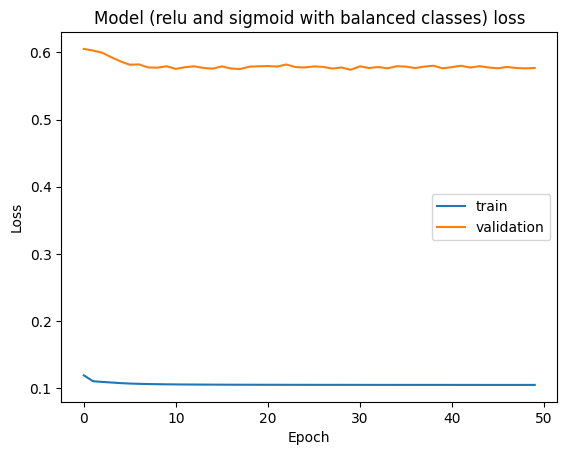

In [31]:
# Summarize history for loss
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model (relu and sigmoid with balanced classes) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

In [32]:
# Metrics from the model
metrics_names = model.metrics_names
metrics_values = model.evaluate(X_valid_sc, y_valid)

for name, value in zip(metrics_names, metrics_values):
    print(name, ':', value)

3691/3691 [==============================] - 8s 2ms/step - loss: 0.5767 - accuracy: 0.6741 - precision: 0.1671 - recall: 0.7334 - auc: 0.7741 - binary_crossentropy: 0.5689
loss : 0.5766728520393372
accuracy : 0.6741387248039246
precision : 0.1670963168144226
recall : 0.7334352731704712
auc : 0.7740998268127441
binary_crossentropy : 0.5688828825950623


In [33]:
# Obtaining probabilities values
y_pred_valid_prob = model.predict(X_valid_sc)
y_pred_test_prob = model.predict(X_test_sc)

# Conversion to 0 or 1 labels (0.5 threshold)
y_pred_valid = (y_pred_valid_prob > 0.5).astype(int)
y_pred_test = (y_pred_test_prob > 0.5).astype(int)

406/406 [==============================] - 1s 1ms/step


In [34]:
# Evaluate the model's performance
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Valid accuracy: {accuracy_valid:.5f}')
print(f'Test accuracy: {accuracy_test:.5f}')

Valid accuracy: 0.67414
Test accuracy: 0.77085


In [35]:
# Validation confusion matrix
confusion_matrix(y_valid, y_pred_valid)

array([[72410, 35864],
       [ 2615,  7195]], dtype=int64)

In [36]:
# Test confusion matrix
confusion_matrix(y_test, y_pred_test)

array([[9533, 2658],
       [ 317,  475]], dtype=int64)

In [38]:
# AUC value (valid)
ROC_AUC_valid = ROC_AUC(y_valid, y_pred_valid_prob)
PR_AUC_valid = PR_AUC(y_valid, y_pred_valid_prob)
print(f'(ROC)AUC value for the validation data: {ROC_AUC_valid:.3f}')
print(f'(PR)AUC value for the validation data: {PR_AUC_valid:.3f}')
print('')

# AUC value (test)
ROC_AUC_test = ROC_AUC(y_test, y_pred_test_prob)
PR_AUC_test = PR_AUC(y_test, y_pred_test_prob)
print(f'(ROC)AUC value for the test data: {ROC_AUC_test:.3f}')
print(f'(PR)AUC value for the test data: {PR_AUC_test:.3f}')

(ROC)AUC value for the validation data: 0.774
(PR)AUC value for the validation data: 0.232

(ROC)AUC value for the test data: 0.786
(PR)AUC value for the test data: 0.200


In [39]:
# AUC calculation with sklearn function
auc_valid = roc_auc_score(y_valid, y_pred_valid_prob)
auc_test = roc_auc_score(y_test, y_pred_test_prob)
print('Validation AUC:', auc_valid)
print('Test AUC:', auc_test)

Validation AUC: 0.7741105276628855
Test AUC: 0.7855599510816476


In [40]:
# Epitope rank (valid and test)
c_percentile_valid = get_percentile_score_arr(scores = y_pred_valid, epitopes = y_valid)
c_percentile_test = get_percentile_score_arr(scores = y_pred_test, epitopes = y_test)
c_percentile_valid, c_percentile_test

(0.6353527997019072, 0.7586844334899484)

In [41]:
print('False positive ratio (valid):', confusion_matrix(y_valid, y_pred_valid)[0][1]/len(y_valid))
print('False positive ratio (test):', confusion_matrix(y_test, y_pred_test)[0][1]/len(y_test))

False positive ratio (valid): 0.30371599878052913
False positive ratio (test): 0.2047292613417546


## Change 1: only sigmoid activations with balanced classes

In [42]:
# Parameters definition
loss = 'binary_crossentropy'
act = 'sigmoid'
l2_value = 0.01

# Training and validation of the model
model1, history1 = nn_model(train_data=X_train_sc, y_train=y_train, valid_data=X_valid_sc, y_valid=y_valid, act_fun=act,
                          loss_fun=loss, alpha=l2_value, class_weight_fn=class_weight_calculator)

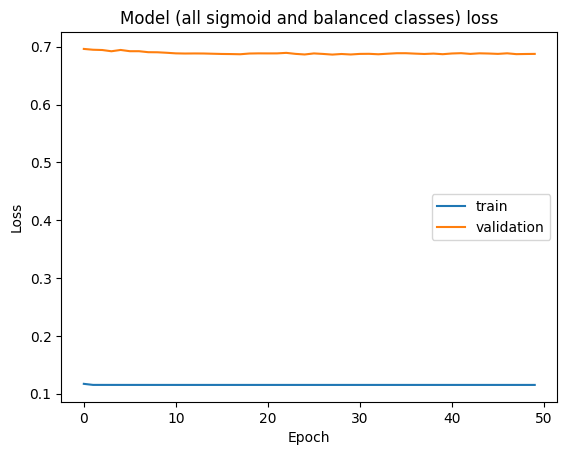

In [43]:
# Summarize history for loss
plt.plot(history1.history['loss'], label = 'train')
plt.plot(history1.history['val_loss'], label='validation')
plt.title('Model (all sigmoid and balanced classes) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

In [44]:
# Metrics from the model
metrics_names = model.metrics_names
metrics_values = model1.evaluate(X_valid_sc, y_valid)

for name, value in zip(metrics_names, metrics_values):
    print(name, ':', value)

3691/3691 [==============================] - 8s 2ms/step - loss: 0.6877 - accuracy: 0.6499 - precision_1: 0.1453 - recall_1: 0.6585 - auc_1: 0.7085 - binary_crossentropy: 0.6868
loss : 0.6876513361930847
accuracy : 0.6498678922653198
precision : 0.145315483212471
recall : 0.6585116982460022
auc : 0.7084625959396362
binary_crossentropy : 0.6868183016777039


In [45]:
# Obtaining probabilities values
y_pred_valid_prob1 = model1.predict(X_valid_sc)
y_pred_test_prob1 = model1.predict(X_test_sc)

# Conversion to 0 or 1 labels (0.5 threshold)
y_pred_valid1 = (y_pred_valid_prob1 > 0.5).astype(int)
y_pred_test1 = (y_pred_test_prob1 > 0.5).astype(int)

406/406 [==============================] - 1s 1ms/step


In [46]:
# Evaluate the model's performance
accuracy_valid1 = accuracy_score(y_valid, y_pred_valid1)
accuracy_test1 = accuracy_score(y_test, y_pred_test1)
print(f'Valid accuracy: {accuracy_valid1:.5f}')
print(f'Test accuracy: {accuracy_test1:.5f}')

Valid accuracy: 0.64987
Test accuracy: 0.69999


In [47]:
# Validation confusion matrix
confusion_matrix(y_valid, y_pred_valid1)

array([[70279, 37995],
       [ 3350,  6460]], dtype=int64)

In [48]:
# Test confusion matrix
confusion_matrix(y_test, y_pred_test1)

array([[8601, 3590],
       [ 305,  487]], dtype=int64)

In [49]:
# AUC value (valid)
ROC_AUC_valid1 = ROC_AUC(y_valid, y_pred_valid_prob1)
PR_AUC_valid1 = PR_AUC(y_valid, y_pred_valid_prob1)
print(f'(ROC)AUC value for the validation data: {ROC_AUC_valid1:.3f}')
print(f'(PR)AUC value for the validation data: {PR_AUC_valid1:.3f}')
print('')

# AUC value (test)
ROC_AUC_test1 = ROC_AUC(y_test, y_pred_test_prob1)
PR_AUC_test1 = PR_AUC(y_test, y_pred_test_prob1)
print(f'(ROC)AUC value for the test data: {ROC_AUC_test1:.3f}')
print(f'(PR)AUC value for the test data: {PR_AUC_test1:.3f}')

(ROC)AUC value for the validation data: 0.715
(PR)AUC value for the validation data: 0.152

(ROC)AUC value for the test data: 0.740
(PR)AUC value for the test data: 0.138


In [50]:
# AUC calculation with sklearn function
auc_valid1 = roc_auc_score(y_valid, y_pred_valid_prob1)
auc_test1 = roc_auc_score(y_test, y_pred_test_prob1)
print('Validation AUC:', auc_valid1)
print('Test AUC:', auc_test1)

Validation AUC: 0.7152751583709069
Test AUC: 0.7398251442320839


In [51]:
# Epitope rank (valid and test)
c_percentile_valid1 = get_percentile_score_arr(scores = y_pred_valid1, epitopes = y_valid)
c_percentile_test1 = get_percentile_score_arr(scores = y_pred_test1, epitopes = y_test)
c_percentile_valid1, c_percentile_test1

(0.6235307069543715, 0.6859739659554802)

In [52]:
print('False positive ratio (validation):', confusion_matrix(y_valid, y_pred_valid1)[0][1]/len(y_valid))
print('False positive ratio (test):', confusion_matrix(y_test, y_pred_test1)[0][1]/len(y_test))

False positive ratio (validation): 0.3217624741709292
False positive ratio (test): 0.27651544327197103


## Change 2: only sigmoid activations without balanced classes

In [53]:
# Parameters definition
loss = 'binary_crossentropy'
act = 'sigmoid'
l2_value = 0.01

# Training and validation of the model
model2, history2 = nn_model(train_data=X_train_sc, y_train=y_train, valid_data=X_valid_sc, y_valid=y_valid, act_fun=act,
                            loss_fun=loss, alpha=l2_value, class_weight_fn=class_weight_calculator, balancing=False)

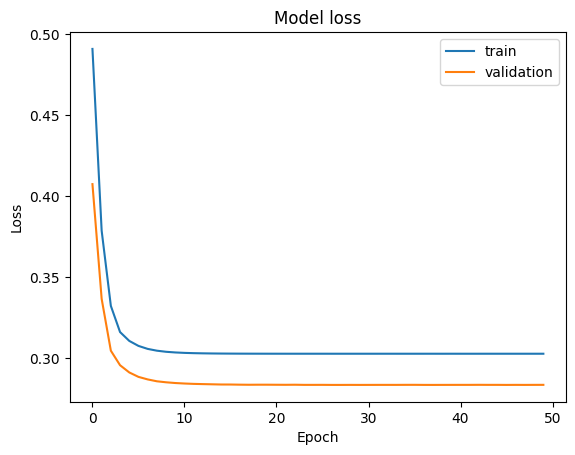

In [54]:
# Summarize history for loss
plt.plot(history2.history['loss'], label = 'train')
plt.plot(history2.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

In [55]:
# Metrics from the model
metrics_names = model.metrics_names
metrics_values = model2.evaluate(X_valid_sc, y_valid)

for name, value in zip(metrics_names, metrics_values):
    print(name, ':', value)

3691/3691 [==============================] - 6s 1ms/step - loss: 0.2834 - accuracy: 0.9169 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - auc_2: 0.7524 - binary_crossentropy: 0.2752
loss : 0.2834497094154358
accuracy : 0.9169235229492188
precision : 0.0
recall : 0.0
auc : 0.7524168491363525
binary_crossentropy : 0.27517178654670715


In [56]:
# Obtaining probabilities values
y_pred_valid_prob2 = model2.predict(X_valid_sc)
y_pred_test_prob2 = model2.predict(X_test_sc)

# Conversion to 0 or 1 labels (0.5 threshold)
y_pred_valid2 = (y_pred_valid_prob2 > 0.5).astype(int)
y_pred_test2 = (y_pred_test_prob2 > 0.5).astype(int)

406/406 [==============================] - 0s 1ms/step


In [57]:
# Evaluate the model's performance
accuracy_valid2 = accuracy_score(y_valid, y_pred_valid2)
accuracy_test2 = accuracy_score(y_test, y_pred_test2)
print(f'Valid accuracy: {accuracy_valid2:.5f}')
print(f'Test accuracy: {accuracy_test2:.5f}')

Valid accuracy: 0.91692
Test accuracy: 0.93900


In [58]:
# Validation confusion matrix
confusion_matrix(y_valid, y_pred_valid2)

array([[108274,      0],
       [  9810,      0]], dtype=int64)

In [59]:
# Test confusion matrix
confusion_matrix(y_test, y_pred_test2)

array([[12191,     0],
       [  792,     0]], dtype=int64)

In [60]:
# AUC value (valid)
ROC_AUC_valid2 = ROC_AUC(y_valid, y_pred_valid_prob2)
PR_AUC_valid2 = PR_AUC(y_valid, y_pred_valid_prob2)
print(f'(ROC)AUC value for the validation data: {ROC_AUC_valid2:.3f}')
print(f'(PR)AUC value for the validation data: {PR_AUC_valid2:.3f}')
print('')

# AUC value (test)
ROC_AUC_test2 = ROC_AUC(y_test, y_pred_test_prob2)
PR_AUC_test2 = PR_AUC(y_test, y_pred_test_prob2)
print(f'(ROC)AUC value for the test data: {ROC_AUC_test2:.3f}')
print(f'(PR)AUC value for the test data: {PR_AUC_test2:.3f}')

(ROC)AUC value for the validation data: 0.754
(PR)AUC value for the validation data: 0.193

(ROC)AUC value for the test data: 0.774
(PR)AUC value for the test data: 0.175


In [61]:
# AUC calculation with sklearn function
auc_valid2 = roc_auc_score(y_valid, y_pred_valid_prob2)
auc_test2 = roc_auc_score(y_test, y_pred_test_prob2)
print('Validation AUC:', auc_valid)
print('Test AUC:', auc_test)

Validation AUC: 0.7741105276628855
Test AUC: 0.7855599510816476


In [62]:
# Epitope rank (valid and test)
c_percentile_valid2 = get_percentile_score_arr(scores = y_pred_valid2, epitopes = y_valid)
c_percentile_test2 = get_percentile_score_arr(scores = y_pred_test2, epitopes = y_test)
c_percentile_valid2, c_percentile_test2

(0.0, 0.0)

In [63]:
print('False positive ratio (validation):', confusion_matrix(y_valid, y_pred_valid2)[0][1]/len(y_valid))
print('False positive ratio (test):', confusion_matrix(y_test, y_pred_test2)[0][1]/len(y_test))

False positive ratio (validation): 0.0
False positive ratio (test): 0.0


## Change 3: only sigmoid activations without balanced classes and without regularization (no batch)

In [78]:
# Neuronal network model with one layer
def nn_model_nobatch(train_data, y_train, valid_data, y_valid, act_fun, loss_fun, alpha, class_weight_fn, balancing=True):
    
    '''
    Function to create and train/validate the feed-forward neuronal network with only 1 hidden layer
        -'train_data': X train standardized
        -'y_train': training labels
        -'valid_data': X validation standardized
        -'y_valid': validation labels
        -'act_fun': activation function
        -'loss_fun': loss function
        -'class_weight_calculator': function to calculate the weights for each class
        -'balancing': True/False argument for incorporating balancing in classes
    
    Output:
        -'model': neural network model trained
        -'history': attributes obtained during fitting the model
    '''
    
    # Calculation of the class weights with function previously defined
    class_weight = class_weight_fn(y_train)
    
    # Normalization of the class_weight to sum 1
    tot = class_weight[0] + class_weight[1]
    class_weight[0] = class_weight[0]/tot
    class_weight[1] = class_weight[1]/tot
    
    # Implementation of keras for creating a sequential model with 1 layer
    tf.random.set_seed(1234)
    from keras.layers import Dense, Dropout
    from keras import regularizers, metrics
    
    model = keras.Sequential()
    # Input layer with train_data.shape neurons and a hidden layer with 1 neuron
    model.add(Dense(1, activation=act_fun, input_shape=train_data.shape[1:], kernel_regularizer=regularizers.l2(alpha)))
    # Output layer with sigmoid activation (better for binary classification)
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(alpha)))
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=loss_fun, metrics=
                  ['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC(), loss_fun])
    
    if (balancing == True):
        history = model.fit(train_data, y_train, epochs = 50, verbose=0, class_weight=class_weight, 
                            validation_data = (valid_data, y_valid))
    else:
        history = model.fit(train_data, y_train, epochs = 50, verbose=0, 
                            validation_data = (valid_data, y_valid))
    
    return(model, history)

In [79]:
# Parameters definition
loss = 'binary_crossentropy'
act = 'sigmoid'
l2_value = None

# Training and validation of the model
model3, history3 = nn_model_nobatch(train_data=X_train_sc, y_train=y_train, valid_data=X_valid_sc, y_valid=y_valid, act_fun=act,
                            loss_fun=loss, alpha=l2_value, class_weight_fn=class_weight_calculator, balancing=False)

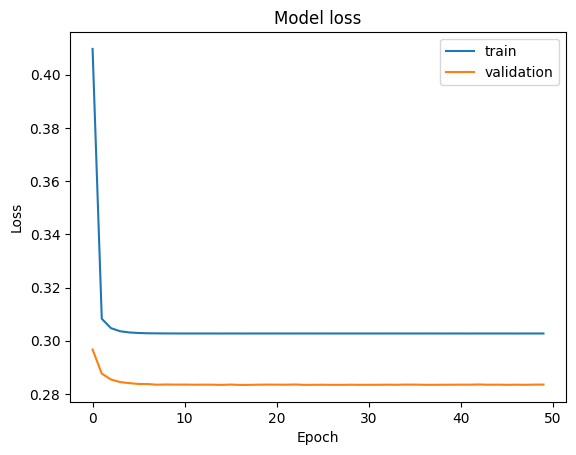

In [80]:
# Summarize history for loss
plt.plot(history3.history['loss'], label = 'train')
plt.plot(history3.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

In [81]:
# Metrics from the model
metrics_names = model.metrics_names
metrics_values = model3.evaluate(X_valid_sc, y_valid)

for name, value in zip(metrics_names, metrics_values):
    print(name, ':', value)

3691/3691 [==============================] - 9s 2ms/step - loss: 0.2835 - accuracy: 0.9169 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - auc_4: 0.7503 - binary_crossentropy: 0.2752
loss : 0.283510684967041
accuracy : 0.9169235229492188
precision : 0.0
recall : 0.0
auc : 0.7502709627151489
binary_crossentropy : 0.27517881989479065


In [82]:
# Obtaining probabilities values
y_pred_valid_prob3 = model3.predict(X_valid_sc)
y_pred_test_prob3 = model3.predict(X_test_sc)

# Conversion to 0 or 1 labels (0.5 threshold)
y_pred_valid3 = (y_pred_valid_prob3 > 0.5).astype(int)
y_pred_test3 = (y_pred_test_prob3 > 0.5).astype(int)

406/406 [==============================] - 1s 3ms/step


In [83]:
# Evaluate the model's performance
accuracy_valid3 = accuracy_score(y_valid, y_pred_valid3)
accuracy_test3 = accuracy_score(y_test, y_pred_test3)
print(f'Valid accuracy: {accuracy_valid3:.5f}')
print(f'Valid accuracy: {accuracy_test3:.5f}')

Valid accuracy: 0.91692
Valid accuracy: 0.93900


In [84]:
# Validation confusion matrix
confusion_matrix(y_valid, y_pred_valid3)

array([[108274,      0],
       [  9810,      0]], dtype=int64)

In [85]:
# Test confusion matrix
confusion_matrix(y_test, y_pred_test3)

array([[12191,     0],
       [  792,     0]], dtype=int64)

In [86]:
# AUC value (valid)
ROC_AUC_valid3 = ROC_AUC(y_valid, y_pred_valid_prob3)
PR_AUC_valid3 = PR_AUC(y_valid, y_pred_valid_prob3)
print(f'(ROC)AUC value for the validation data: {ROC_AUC_valid3:.3f}')
print(f'(PR)AUC value for the validation data: {PR_AUC_valid3:.3f}')
print('')

# AUC value (test)
ROC_AUC_test3 = ROC_AUC(y_test, y_pred_test_prob3)
PR_AUC_test3 = PR_AUC(y_test, y_pred_test_prob3)
print(f'(ROC)AUC value for the test data: {ROC_AUC_test3:.3f}')
print(f'(PR)AUC value for the test data: {PR_AUC_test3:.3f}')

(ROC)AUC value for the validation data: 0.753
(PR)AUC value for the validation data: 0.191

(ROC)AUC value for the test data: 0.773
(PR)AUC value for the test data: 0.174


In [87]:
# AUC calculation with sklearn function
auc_valid3 = roc_auc_score(y_valid, y_pred_valid_prob3)
auc_test3 = roc_auc_score(y_test, y_pred_test_prob3)
print('Validation AUC:', auc_valid3)
print('Test AUC:', auc_test3)

Validation AUC: 0.7525838136293213
Test AUC: 0.7726335933363658


In [88]:
# Epitope rank (valid and test)
c_percentile_valid3 = get_percentile_score_arr(scores = y_pred_valid3, epitopes = y_valid)
c_percentile_test3 = get_percentile_score_arr(scores = y_pred_test3, epitopes = y_test)
c_percentile_valid3, c_percentile_test3

(0.0, 0.0)

In [89]:
print('False positive ratio (validation):', confusion_matrix(y_valid, y_pred_valid3)[0][1]/len(y_valid))
print('False positive ratio (test):', confusion_matrix(y_test, y_pred_test3)[0][1]/len(y_test))

False positive ratio (validation): 0.0
False positive ratio (test): 0.0


## Change 4: relu and sigmoid activations without balanced classes and without regularization (no batch)

In [90]:
# Parameters definition
loss = 'binary_crossentropy'
act = 'relu'
l2_value = None

# Training and validation of the model
model4, history4 = nn_model_nobatch(train_data=X_train_sc, y_train=y_train, valid_data=X_valid_sc, y_valid=y_valid, act_fun=act,
                            loss_fun=loss, alpha=l2_value, class_weight_fn=class_weight_calculator, balancing=False)

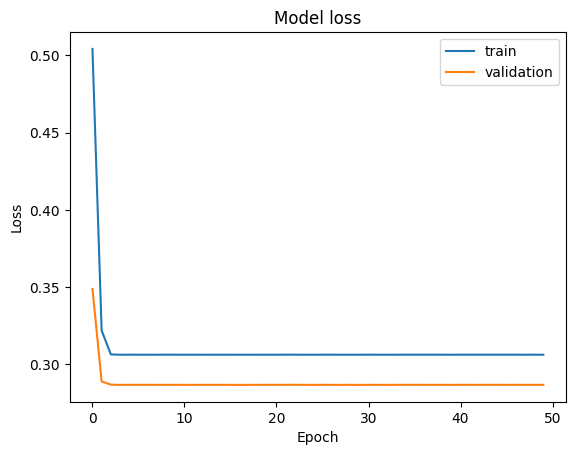

In [91]:
# Summarize history for loss
plt.plot(history4.history['loss'], label = 'train')
plt.plot(history4.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

In [92]:
# Metrics from the model
metrics_names = model.metrics_names
metrics_values = model4.evaluate(X_valid_sc, y_valid)

for name, value in zip(metrics_names, metrics_values):
    print(name, ':', value)

3691/3691 [==============================] - 8s 2ms/step - loss: 0.2867 - accuracy: 0.9169 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - auc_5: 0.5000 - binary_crossentropy: 0.2867
loss : 0.28666624426841736
accuracy : 0.9169235229492188
precision : 0.0
recall : 0.0
auc : 0.5
binary_crossentropy : 0.28666624426841736


In [93]:
# Obtaining probabilities values
y_pred_valid_prob4 = model4.predict(X_valid_sc)
y_pred_test_prob4 = model4.predict(X_test_sc)

# Conversion to 0 or 1 labels (0.5 threshold)
y_pred_valid4 = (y_pred_valid_prob4 > 0.5).astype(int)
y_pred_test4 = (y_pred_test_prob4 > 0.5).astype(int)

406/406 [==============================] - 0s 1ms/step


In [94]:
# Evaluate the model's performance
accuracy_valid4 = accuracy_score(y_valid, y_pred_valid4)
accuracy_test4 = accuracy_score(y_test, y_pred_test4)
print(f'Valid accuracy: {accuracy_valid4:.5f}')
print(f'Valid accuracy: {accuracy_test4:.5f}')

Valid accuracy: 0.91692
Valid accuracy: 0.93900


In [95]:
# Validation confusion matrix
confusion_matrix(y_valid, y_pred_valid4)

array([[108274,      0],
       [  9810,      0]], dtype=int64)

In [96]:
# Test confusion matrix
confusion_matrix(y_test, y_pred_test4)

array([[12191,     0],
       [  792,     0]], dtype=int64)

In [97]:
# AUC value (valid)
ROC_AUC_valid4 = ROC_AUC(y_valid, y_pred_valid_prob4)
PR_AUC_valid4 = PR_AUC(y_valid, y_pred_valid_prob4)
print(f'(ROC)AUC value for the validation data: {ROC_AUC_valid4:.3f}')
print(f'(PR)AUC value for the validation data: {PR_AUC_valid4:.3f}')
print('')

# AUC value (test)
ROC_AUC_test4 = ROC_AUC(y_test, y_pred_test_prob4)
PR_AUC_test4 = PR_AUC(y_test, y_pred_test_prob4)
print(f'(ROC)AUC value for the test data: {ROC_AUC_test4:.3f}')
print(f'(PR)AUC value for the test data: {PR_AUC_test4:.3f}')

(ROC)AUC value for the validation data: 0.500
(PR)AUC value for the validation data: 0.542

(ROC)AUC value for the test data: 0.500
(PR)AUC value for the test data: 0.531


In [98]:
# AUC calculation with sklearn function
auc_valid4 = roc_auc_score(y_valid, y_pred_valid_prob4)
auc_test4 = roc_auc_score(y_test, y_pred_test_prob4)
print('Validation AUC:', auc_valid4)
print('Test AUC:', auc_test4)

Validation AUC: 0.5
Test AUC: 0.5001230415880568


In [99]:
# Epitope rank (valid and test)
c_percentile_valid4 = get_percentile_score_arr(scores = y_pred_valid4, epitopes = y_valid)
c_percentile_test4 = get_percentile_score_arr(scores = y_pred_test4, epitopes = y_test)
c_percentile_valid4, c_percentile_test4

(0.0, 0.0)

In [100]:
print('False positive ratio (validation):', confusion_matrix(y_valid, y_pred_valid4)[0][1]/len(y_valid))
print('False positive ratio (test):', confusion_matrix(y_test, y_pred_test4)[0][1]/len(y_test))

False positive ratio (validation): 0.0
False positive ratio (test): 0.0


## Change 5: relu and sigmoid activations without balanced classes and without regularization (with batch)

In [101]:
# Parameters definition
loss = 'binary_crossentropy'
act = 'relu'
l2_value = None

# Training and validation of the model
model5, history5 = nn_model(train_data=X_train_sc, y_train=y_train, valid_data=X_valid_sc, y_valid=y_valid, act_fun=act,
                            loss_fun=loss, alpha=l2_value, class_weight_fn=class_weight_calculator, balancing=False)

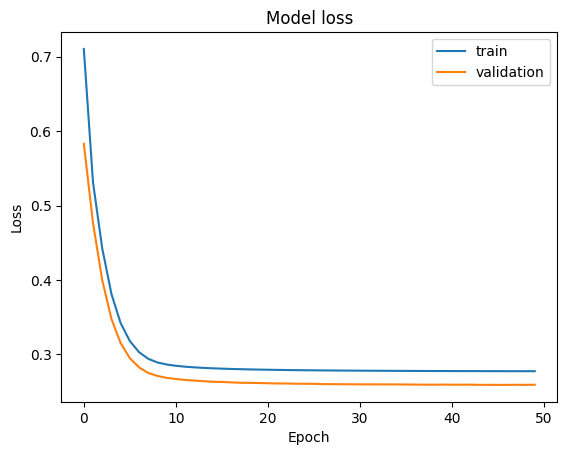

In [102]:
# Summarize history for loss
plt.plot(history5.history['loss'], label = 'train')
plt.plot(history5.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

In [103]:
# Metrics from the model
metrics_names = model.metrics_names
metrics_values = model5.evaluate(X_valid_sc, y_valid)

for name, value in zip(metrics_names, metrics_values):
    print(name, ':', value)

3691/3691 [==============================] - 8s 2ms/step - loss: 0.2592 - accuracy: 0.9169 - precision_6: 0.3000 - recall_6: 3.0581e-04 - auc_6: 0.7815 - binary_crossentropy: 0.2477
loss : 0.2592238783836365
accuracy : 0.9168896675109863
precision : 0.30000001192092896
recall : 0.0003058103902731091
auc : 0.7814557552337646
binary_crossentropy : 0.24770700931549072


In [104]:
# Obtaining probabilities values
y_pred_valid_prob5 = model5.predict(X_valid_sc)
y_pred_test_prob5 = model5.predict(X_test_sc)

# Conversion to 0 or 1 labels (0.5 threshold)
y_pred_valid5 = (y_pred_valid_prob5 > 0.5).astype(int)
y_pred_test5 = (y_pred_test_prob5 > 0.5).astype(int)

406/406 [==============================] - 1s 2ms/step


In [105]:
# Evaluate the model's performance
accuracy_valid5 = accuracy_score(y_valid, y_pred_valid5)
accuracy_test5 = accuracy_score(y_test, y_pred_test5)
print(f'Valid accuracy: {accuracy_valid5:.5f}')
print(f'Valid accuracy: {accuracy_test5:.5f}')

Valid accuracy: 0.91689
Valid accuracy: 0.93900


In [106]:
# Validation confusion matrix
confusion_matrix(y_valid, y_pred_valid5)

array([[108267,      7],
       [  9807,      3]], dtype=int64)

In [107]:
# Test confusion matrix
confusion_matrix(y_test, y_pred_test5)

array([[12191,     0],
       [  792,     0]], dtype=int64)

In [108]:
# AUC value (valid)
ROC_AUC_valid5 = ROC_AUC(y_valid, y_pred_valid_prob5)
PR_AUC_valid5 = PR_AUC(y_valid, y_pred_valid_prob5)
print(f'(ROC)AUC value for the validation data: {ROC_AUC_valid5:.3f}')
print(f'(PR)AUC value for the validation data: {PR_AUC_valid5:.3f}')
print('')

# AUC value (test)
ROC_AUC_test5 = ROC_AUC(y_test, y_pred_test_prob5)
PR_AUC_test5 = PR_AUC(y_test, y_pred_test_prob5)
print(f'(ROC)AUC value for the test data: {ROC_AUC_test5:.3f}')
print(f'(PR)AUC value for the test data: {PR_AUC_test5:.3f}')

(ROC)AUC value for the validation data: 0.782
(PR)AUC value for the validation data: 0.241

(ROC)AUC value for the test data: 0.787
(PR)AUC value for the test data: 0.213


In [109]:
# AUC calculation with sklearn function
auc_valid5 = roc_auc_score(y_valid, y_pred_valid_prob5)
auc_test5 = roc_auc_score(y_test, y_pred_test_prob5)
print('Validation AUC:', auc_valid5)
print('Test AUC:', auc_test5)

Validation AUC: 0.7817045715953355
Test AUC: 0.7873190418664539


In [110]:
# Epitope rank (valid and test)
c_percentile_valid5 = get_percentile_score_arr(scores = y_pred_valid5, epitopes = y_valid)
c_percentile_test5 = get_percentile_score_arr(scores = y_pred_test5, epitopes = y_test)
c_percentile_valid5, c_percentile_test5

(0.9999153145218658, 0.0)

In [111]:
print('False positive ratio (validation):', confusion_matrix(y_valid, y_pred_valid5)[0][1]/len(y_valid))
print('False positive ratio (test):', confusion_matrix(y_test, y_pred_test5)[0][1]/len(y_test))

False positive ratio (validation): 5.9279834693946685e-05
False positive ratio (test): 0.0


## Change 6: relu and sigmoid activations without balanced classes and with regularization (with batch)

In [112]:
# Parameters definition
loss = 'binary_crossentropy'
act = 'relu'
l2_value = 0.01

# Training and validation of the model
model6, history6 = nn_model(train_data=X_train_sc, y_train=y_train, valid_data=X_valid_sc, y_valid=y_valid, act_fun=act,
                            loss_fun=loss, alpha=l2_value, class_weight_fn=class_weight_calculator, balancing=False)

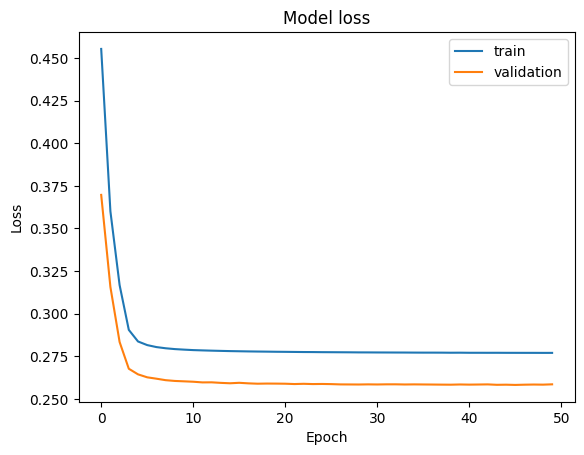

In [113]:
# Summarize history for loss
plt.plot(history6.history['loss'], label = 'train')
plt.plot(history6.history['val_loss'], label='validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

In [114]:
# Metrics from the model
metrics_names = model.metrics_names
metrics_values = model6.evaluate(X_valid_sc, y_valid)

for name, value in zip(metrics_names, metrics_values):
    print(name, ':', value)

3691/3691 [==============================] - 8s 2ms/step - loss: 0.2585 - accuracy: 0.9169 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - auc_7: 0.7820 - binary_crossentropy: 0.2468
loss : 0.25854671001434326
accuracy : 0.9169235229492188
precision : 0.0
recall : 0.0
auc : 0.7820013761520386
binary_crossentropy : 0.24683313071727753


In [115]:
# Obtaining probabilities values
y_pred_valid_prob6 = model6.predict(X_valid_sc)
y_pred_test_prob6 = model6.predict(X_test_sc)

# Conversion to 0 or 1 labels (0.5 threshold)
y_pred_valid6 = (y_pred_valid_prob6 > 0.5).astype(int)
y_pred_test6 = (y_pred_test_prob6 > 0.5).astype(int)

406/406 [==============================] - 1s 2ms/step


In [116]:
# Evaluate the model's performance
accuracy_valid6 = accuracy_score(y_valid, y_pred_valid6)
accuracy_test6 = accuracy_score(y_test, y_pred_test6)
print(f'Valid accuracy: {accuracy_valid6:.5f}')
print(f'Valid accuracy: {accuracy_test6:.5f}')

Valid accuracy: 0.91692
Valid accuracy: 0.93900


In [117]:
# Validation confusion matrix
confusion_matrix(y_valid, y_pred_valid6)

array([[108274,      0],
       [  9810,      0]], dtype=int64)

In [118]:
# Test confusion matrix
confusion_matrix(y_test, y_pred_test6)

array([[12191,     0],
       [  792,     0]], dtype=int64)

In [120]:
# AUC value (valid)
ROC_AUC_valid6 = ROC_AUC(y_valid, y_pred_valid_prob6)
PR_AUC_valid6 = PR_AUC(y_valid, y_pred_valid_prob6)
print(f'(ROC)AUC value for the validation data: {ROC_AUC_valid6:.3f}')
print(f'(PR)AUC value for the validation data: {PR_AUC_valid6:.3f}')
print('')

# AUC value (test)
ROC_AUC_test6 = ROC_AUC(y_test, y_pred_test_prob6)
PR_AUC_test6 = PR_AUC(y_test, y_pred_test_prob6)
print(f'(ROC)AUC value for the test data: {ROC_AUC_test6:.3f}')
print(f'(PR)AUC value for the test data: {PR_AUC_test6:.3f}')

(ROC)AUC value for the validation data: 0.782
(PR)AUC value for the validation data: 0.249

(ROC)AUC value for the test data: 0.789
(PR)AUC value for the test data: 0.214


In [121]:
# AUC calculation with sklearn function
auc_valid6 = roc_auc_score(y_valid, y_pred_valid_prob6)
auc_test6 = roc_auc_score(y_test, y_pred_test_prob6)
print('Validation AUC:', auc_valid6)
print('Test AUC:', auc_test6)

Validation AUC: 0.7822224393253671
Test AUC: 0.7891392391638474


In [122]:
# Epitope rank (valid and test)
c_percentile_valid6 = get_percentile_score_arr(scores = y_pred_valid6, epitopes = y_valid)
c_percentile_test6 = get_percentile_score_arr(scores = y_pred_test6, epitopes = y_test)
c_percentile_valid6, c_percentile_test6

(0.0, 0.0)

In [123]:
print('False positive ratio (validation):', confusion_matrix(y_valid, y_pred_valid6)[0][1]/len(y_valid))
print('False positive ratio (test):', confusion_matrix(y_test, y_pred_test6)[0][1]/len(y_test))

False positive ratio (validation): 0.0
False positive ratio (test): 0.0
